In [2]:
import numpy as np
import scipy
from scipy import stats

import pandas as pd

import pymc3 as pm

import arviz as az
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import ipywidgets as ipyw

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
# Define colors 
viridish = [(0.2823529411764706, 0.11372549019607843, 0.43529411764705883, 1.0),
            (0.1450980392156863, 0.6705882352941176, 0.5098039215686274, 1.0),
            (0.6901960784313725, 0.8666666666666667, 0.1843137254901961, 1.0)]

# Bayesian modeling notes

These notebooks consist of my notes, codes and solutions to exercises from the book ["Bayesian modeling and computation in Python" (Martin et al., 2022)](https://bayesiancomputationbook.com/welcome.html)


## Linear models

### Data + EDA

In [4]:
# Get penguin data
penguins = pd.read_csv('./data/penguins_size.csv')

# Drop rows with NAs
penguins = penguins.dropna(axis=0)

In [5]:
penguins.shape

(334, 7)

### Model - single specie regression with `flipper_length`

In [6]:
# Get observations
adelie_mass_obs = penguins[penguins.species == 'Adelie']['body_mass_g'].values
adelie_flipper_len_obs = penguins[penguins.species == 'Adelie']['flipper_length_mm'].values

In [7]:
adelie_flipper_len_obs.mean()

190.1027397260274

In [8]:
# Model
with pm.Model() as model_adelie_flipper_reg:
    
    adelie_flipper_len = pm.Data('adelie_flipper_len', adelie_flipper_len_obs)
    
    ### Prior params ###
    # SD
    sigma = pm.HalfStudentT('sigma', 100, 2000)
    
    # Linear coefs
    beta_0 = pm.Normal('beta_0', 0, 4000)
    beta_1 = pm.Normal('beta_1', 0, 4000)
    
    # Mu
    mu = pm.Deterministic('mu', beta_0 + beta_1 * adelie_flipper_len)
    
    
    ### Likelihood X prior ###
    mass = pm.Normal(
        'mass', 
        mu=mu,
        sigma=sigma,
        observed=adelie_mass_obs)
    
    inference_data_adelie_flipper_reg = pm.sample(return_inferencedata=True, target_accept=.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_1, beta_0, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [9]:
# Summarize
az.summary(inference_data_adelie_flipper_reg, var_names=['beta_0', 'beta_1']).round(1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,-2312.8,977.5,-4143.1,-579.2,33.6,23.8,842.0,1030.0,1.0
beta_1,31.7,5.1,22.5,41.2,0.2,0.1,838.0,1029.0,1.0


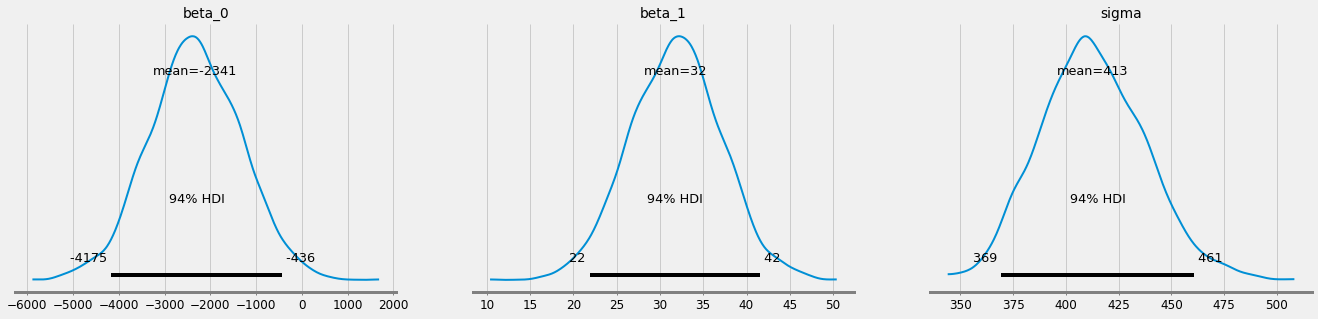

In [47]:
# Plot posterior
az.plot_posterior(
    inference_data_adelie_flipper_reg, 
    var_names=['beta_0', 'beta_1', 'sigma'],
    textsize=12, 
    lw=2
)
plt.show()

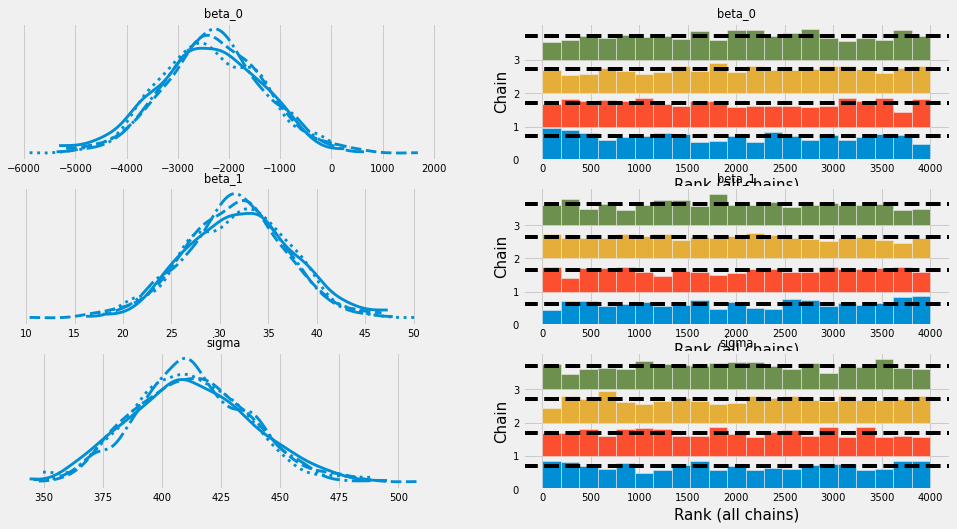

In [48]:
# Plot traces
az.plot_trace(
    inference_data_adelie_flipper_reg, 
    var_names=['beta_0', 'beta_1', 'sigma'],
    compact=True, 
    figsize=(15, 8),
    divergences="bottom", 
    kind="rank_bars")
plt.show()

Chains and ranks look decent, but not perfect.

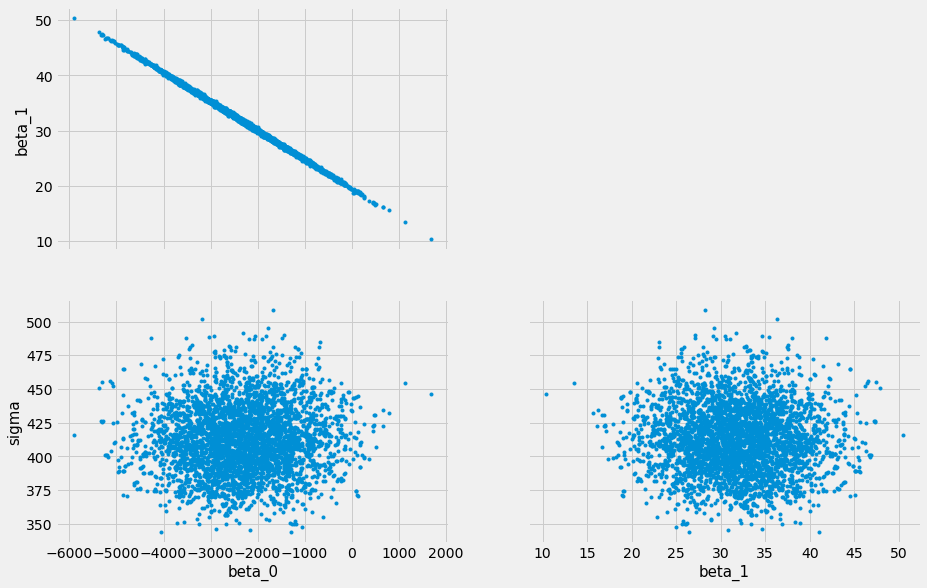

In [49]:
# Check divergences
az.plot_pair(inference_data_adelie_flipper_reg, var_names=['beta_0', 'beta_1', 'sigma'], divergences=True)
plt.show()

### Predictions - posterior

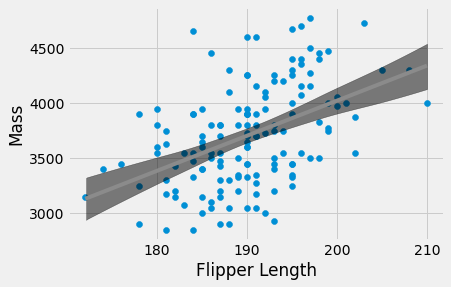

In [63]:
fig, ax = plt.subplots()
alpha_m = inference_data_adelie_flipper_reg.posterior.mean().to_dict()["data_vars"]["beta_0"]["data"]
beta_m = inference_data_adelie_flipper_reg.posterior.mean().to_dict()["data_vars"]["beta_1"]["data"]

flipper_len = np.linspace(adelie_flipper_len_obs.min(), adelie_flipper_len_obs.max(), 100)

flipper_len_mean = alpha_m + beta_m * flipper_len

ax.plot(flipper_len, flipper_len_mean, c='C4',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

ax.scatter(adelie_flipper_len_obs, adelie_mass_obs)

# Figure out how to do this from inference data
az.plot_hdi(
    adelie_flipper_len_obs, 
    inference_data_adelie_flipper_reg.posterior['mu'], 
    hdi_prob=0.94, 
    color='k', 
    ax=ax)

ax.set_xlabel('Flipper Length')
ax.set_ylabel('Mass')
plt.show()

### Predictions - posterior predictive

In [60]:
with model_adelie_flipper_reg:
    
    # Set data to mean observed flipper len
    pm.set_data({
        'adelie_flipper_len': adelie_flipper_len_obs.mean().reshape(1)
    })
    
    # Get predictions
    posterior_preds = pm.sample_posterior_predictive(
        inference_data_adelie_flipper_reg.posterior,
        var_names=['mass', 'mu']
    )

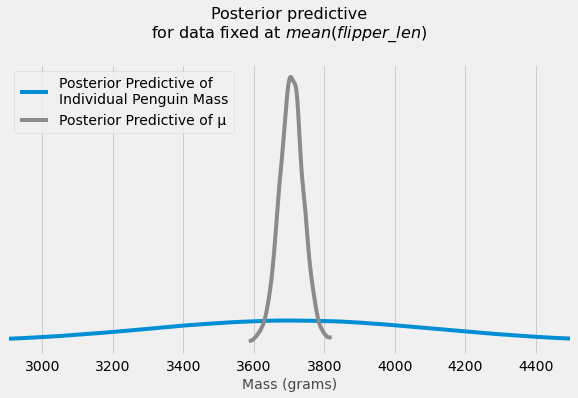

In [83]:
fig, ax = plt.subplots(figsize=(9, 5))

az.plot_dist(
    posterior_preds['mass'], 
    label="Posterior Predictive of \nIndividual Penguin Mass", 
    ax=ax)

az.plot_dist(
    posterior_preds['mu'], 
    label="Posterior Predictive of μ", 
    color="C4", 
    ax=ax)

ax.set_xlim(2900, 4500)
ax.legend(loc=2)
ax.set_xlabel('Mass (grams)', fontsize=14, alpha=.7)
ax.set_yticks([])

plt.title('Posterior predictive\nfor data fixed at $mean(flipper\_len)$\n', fontsize=16)
plt.show()